In [22]:
1000 % 2

0

In [72]:
import pandas as pd
import numpy as np

class Load_Balancer:
    def __init__(self, beta,number_of_servers,number_of_task):
        self.number_of_task=number_of_task
        self.number_of_servers=number_of_servers
        self.processing = {t:self.processing_time(beta=beta) for t in range(self.number_of_task)}
        self.arrival_times = self.inter_arrival_times(q=3 / 5, T0=1, mean_Y=10, N=self.number_of_task)
        self.servers = {i: {"que": [], "proces": 0 ,"processing_task":0} for i in range(0, number_of_servers)}
        self.task = {i:{"sum":0,"entrance_time": 0, "quiting_time": 0,
                        "processing_time":self.processing[i],"arrival_time":self.arrival_times[i],
                        "server":0} for i in range(len(self.processing))}
        self.is_server_bt = [1]*20
        self.global_time=0
        self.current_task=0
        self.next_arriving_time=0
        self.threshold=0
        self.d=3
        self.time_interval_update = 1000

    def inter_arrival_times(self,q, T0, mean_Y, N):
        inter_times = {}
        for i in range(N):
            r = np.random.random()
            if r <= q:
                T = T0
            else:
                T = T0 - mean_Y * np.log(np.random.random())
            inter_times[i] = int(round(T))
        return (inter_times)

    def processing_time(self,beta):
        expected_service_time = beta * 2
        r = np.random.random()
        confront_min = []
        confront_min.append(round(np.log(r) * np.log(r) * beta))
        confront_min.append(100 * expected_service_time)
        min_temp = min(confront_min)
        confront_max = []
        confront_max.append(1)
        confront_max.append(int(min_temp))
        weibell_rv = max(confront_max)
        return (weibell_rv)

    def iterate_one_task(self):
        min_que_holder = float("+inf")
        min_que_server = 0

        for server in self.servers:
            is_processing = 1 if self.servers[server]["proces"] else 0
            if len(self.servers[server]["que"]) + is_processing < min_que_holder:
                min_que_holder = len(self.servers[server]["que"])+is_processing
                min_que_server = server
        self.task[self.current_task]["server"]=min_que_server
        self.servers[min_que_server]["que"].append(self.current_task)
        if self.servers[min_que_server]["proces"] == 0:
            item_in_proces=self.servers[min_que_server]["que"].pop(0)
            self.servers[min_que_server]["proces"]=self.processing[item_in_proces]
            self.servers[min_que_server]["processing_task"] = item_in_proces

        self.task[self.current_task]["entrance_time"] = self.global_time
        self.current_task += 1
        try:
            self.next_arriving_time=self.arrival_times[self.current_task]
        except:
            print("Last Element")
            self.next_arriving_time=self.arrival_times[self.current_task -1 ]
    
    
    def iterate_one_task_JBT(self):
        
        ''' the following part is new respect to Vedat's '''
        available_servers = []
        # check which servers have threshold below t and append them in the list below
        for server in range(self.number_of_servers) :
            if self.is_server_bt[server] == 1:
                available_servers.append(server)
        # if there are no servers below th then select a random server
        if len(available_servers) == 0:
            random_server = np.random.randint(0,self.number_of_servers)
        else:
        # otherwise select one of the servers that are below treshold
            random_index_server = np.random.randint(0,len(available_servers))
            random_server = available_servers[random_index_server]

        self.is_server_bt[random_server] = 0
        self.servers[random_server]['que'].append(self.current_task)
        self.task[self.current_task]['server'] = random_server
        
        ''' the following part is new respect to Vedat's '''
        if self.servers[random_server]["proces"] == 0:
            item_in_proces=self.servers[random_server]["que"].pop(0)
            self.servers[random_server]["proces"]=self.processing[item_in_proces]
            self.servers[random_server]["processing_task"] = item_in_proces
            # if the que is less than threshold put it in the list of servers that are below threshold
            if len(self.servers[random_server]['que']) < self.threshold:
                self.is_server_bt[random_server] = 1

        self.task[self.current_task]["entrance_time"] = self.global_time
        self.current_task += 1
        try:
            self.next_arriving_time=self.arrival_times[self.current_task]
        except:
            print("Last Element")
            self.next_arriving_time=self.arrival_times[self.current_task -1 ]  
    
    def iterate_one_task_POD (self):
        Len_of_Random_Selected_Que_List = list()
        num_of_shortest_que_server=0
        num_task_shortest_que= self.number_of_task
        sampling = np.random.randint(0,self.number_of_servers, size=self.d)
        for i in range(self.d):
            Len_of_Random_Selected_Que_List.append((sampling[i],len(self.servers[sampling[i]]['que'])))
    
        for i in range(len(Len_of_Random_Selected_Que_List)):
            if (Len_of_Random_Selected_Que_List[i][1] <= num_task_shortest_que):
                num_task_shortest_que = Len_of_Random_Selected_Que_List[i][1]
                min_que_server = Len_of_Random_Selected_Que_List[i][0]
                
        self.task[self.current_task]["server"]=min_que_server
        self.servers[min_que_server]["que"].append(self.current_task)
        if self.servers[min_que_server]["proces"] == 0:
            item_in_proces=self.servers[min_que_server]["que"].pop(0)
            self.servers[min_que_server]["proces"]=self.processing[item_in_proces]
            self.servers[min_que_server]["processing_task"] = item_in_proces

        self.task[self.current_task]["entrance_time"] = self.global_time
        self.current_task += 1
        try:
            self.next_arriving_time=self.arrival_times[self.current_task]
        except:
            #print("Last Element")
            self.next_arriving_time=self.arrival_times[self.current_task -1 ]
    
    
    
    
    def iterate_over_global_time_JBT(self):
        for time in range(self.next_arriving_time):
            self.global_time += 1
            for server in self.servers:
                if self.servers[server]["proces"] > 0:
                    self.servers[server]["proces"] -= 1
                    if self.servers[server]["proces"] == 0:
                        self.task[self.servers[server]["processing_task"]]["quiting_time"]=self.global_time
                        if len(self.servers[server]["que"]) > 0 :
                            item_in_proces=self.servers[server]["que"].pop(0)
                            self.servers[server]["proces"] = self.processing[item_in_proces]
                            self.servers[server]["processing_task"] = item_in_proces     
                            
            ''' the following part is new respect to Vedat's '''
                # at each time verify the que lenghts and update the list
                if len(self.servers[server]['que']) < self.threshold:
                    self.is_server_bt[server]=1
            
            '''updating of the threshold'''
            
            # at multiple of time_interval_update we update the treshold
            if self.global_time % self.time_interval_update == 0:
                # take d random servers
                random_d_servers = np.random.randint(0,self.number_of_servers, size =self.d)
                random_d_servers_ques = []
                # for each of the servesr check their queue and take the minimum value and put it as threshold
                for server in random_d_servers:
                    random_d_servers_ques.append(len(self.servers[server]['que']))
                self.threshold = min(random_d_servers_ques)
                #print("th: ",self.threshold)
    
    def iterate_over_global_time(self):
        for time in range(self.next_arriving_time):
            self.global_time += 1
            for server in self.servers:
                if self.servers[server]["proces"] > 0:
                    self.servers[server]["proces"] -= 1
                    if self.servers[server]["proces"] == 0:
                        self.task[self.servers[server]["processing_task"]]["quiting_time"]=self.global_time
                        if len(self.servers[server]["que"]) > 0 :
                            item_in_proces=self.servers[server]["que"].pop(0)
                            self.servers[server]["proces"] = self.processing[item_in_proces]
                            self.servers[server]["processing_task"] = item_in_proces

    def finishing_all_the_task(self):
        for server in self.servers:
            initial_global_for_each_server=self.global_time
            while len(self.servers[server]["que"]) :
                print(self.servers[server]["proces"])
                if self.servers[server]["proces"] > 0:
                    initial_global_for_each_server += self.servers[server]["proces"]
                    self.task[self.servers[server]["processing_task"]]["quiting_time"] = initial_global_for_each_server
                    next_item_in_que=self.servers[server]["que"].pop(0)
                    self.servers[server]["processing_task"]=next_item_in_que
                    self.servers[server]["proces"]=self.processing[next_item_in_que]
            initial_global_for_each_server += self.servers[server]["proces"]
            self.task[self.servers[server]["processing_task"]]["quiting_time"] = initial_global_for_each_server
            self.servers[server]["processing_task"] = "nothing_left"
            self.servers[server]["proces"] = "idle"


    def	main(self):
        for i in range(self.number_of_task):
            load_balance.iterate_one_task_JBT()
            load_balance.iterate_over_global_time_JBT()

        load_balance.finishing_all_the_task()

In [67]:
import matplotlib.pyplot as plt

In [73]:
if __name__ == "__main__":
    avg_times3=[]
    for b in [40,41,42,43,44,45,46,47,48,49]:
        print(b)
        load_balance=Load_Balancer(beta=b,number_of_servers=20,number_of_task=200000)
        load_balance.main()
        print("Total Amount of Time For Processing All Task",load_balance.global_time)
        print("Total Time of All Task",sum(load_balance.processing.values()))
        df=pd.DataFrame.from_dict(load_balance.task,orient="index")
        df["sum"]=df["quiting_time"]-df["entrance_time"]
        df.to_csv("output1.csv")
        avg_times3.append(df[1000:]['sum'].mean())

40
Last Element
629
50
55
8
74
3
7
2
3
43
636
27
260
572
19
122
4
1
37
1
1
112
413
94
1
529
31
1
1
13
409
204
5
159
164
44
595
1
1
5
203
1
5
19
7
71
493
7
1
158
1071
226
1
403
95
110
1
75
42
13
185
19
34
71
Total Amount of Time For Processing All Task 999121
Total Time of All Task 16054022
41
Last Element
439
1
10
3
306
13
1
3
1
25
50
4
124
12
73
99
50
22
41
1
1
143
2
243
69
10
125
202
48
8
132
43
1815
3
4
1
141
13
13
74
180
24
119
235
38
6
3
13
53
36
13
1
31
142
1
10
75
49
58
67
24
1
150
112
58
4
124
2
2
26
1
50
19
45
56
66
57
211
2
34
111
63
8
50
19
52
80
1
30
3
1
30
3
69
2
4
133
174
5
284
47
1
190
190
2
273
37
11
254
379
1473
5
113
1
5
3
10
1
7
1
2
389
1
1
14
21
39
24
Total Amount of Time For Processing All Task 1001058
Total Time of All Task 16480511
42
Last Element
461
1
323
158
32
18
8
308
15
365
1
173
6
5
1
189
6
1
208
56
38
87
1
1
750
34
715
1
21
4
153
138
216
40
33
137
3
77
4
115
40
68
173
5
112
7
21
1
4
1
1
10
64
426
63
477
300
8
1
1
408
3
8
425
5
60
1
3
25
36
3
868
3
98
1
52

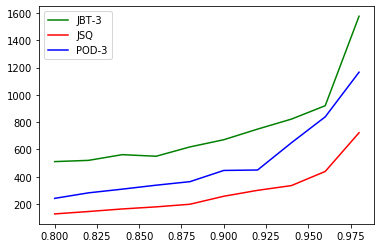

In [74]:
betas = np.array([40,41,42,43,44,45,46,47,48,49])/50
plt.plot(betas,avg_times3, color='green', label='JBT-3')
plt.plot(betas,avg_times2, color='red', label='JSQ')
plt.plot(betas,avg_times, color='blue', label='POD-3')
plt.legend()
plt.show()